# Import thu vien

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
import logging
logging.basicConfig(filename = 'app.log',
                    level = logging.INFO,
                    format = '%(asctime)s - %(levelname)s - %(message)s'
                    )
logging.info('=========== Starting the data analysis script ===========')

## a) Đọc dữ liệu từ JSON:
- Sử dụng thư viện json để đọc file JSON
- Chuyển đổi dữ liệu thành DataFrame của pandas
- Kiểm tra và in ra 5 dòng đầu tiên của dữ liệu

In [3]:
def read_data_json(file_path):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
            data = pd.json_normalize(data, 'data')
    except Exception as e:
        logging.error(f"Error reading JSON file: {e}")
    return data
data = read_data_json('housing_price_hanoi.json')
data.head()

,month,month_name,date,district,price_per_sqm,total_volume,number_transactions
0,1,Tháng 1,2025-01-15,Ba Đình,125.5,450,28
1,1,Tháng 1,2025-01-15,Hoàn Kiếm,189.3,320,15
2,1,Tháng 1,2025-01-15,Hai Bà Trưng,98.7,680,42
3,2,Tháng 2,2025-02-15,Ba Đình,127.2,520,31
4,2,Tháng 2,2025-02-15,Hoàn Kiếm,192.1,350,18


## b) Làm sạch và chuẩn hóa dữ liệu:
- Kiểm tra các giá trị bị thiếu (NaN, None)
- Chuyển đổi định dạng cột date sang datetime
- Xóa các bản ghi trùng lặp (nếu có)
- Kiểm tra các giá trị ngoại lệ (outliers)

In [4]:
#Kiểm tra dữ liệu
print(data.info())
#Kiem tra null, lap
print(data.isnull().sum())
print(data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                6 non-null      int64  
 1   month_name           6 non-null      object 
 2   date                 6 non-null      object 
 3   district             6 non-null      object 
 4   price_per_sqm        6 non-null      float64
 5   total_volume         6 non-null      int64  
 6   number_transactions  6 non-null      int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 464.0+ bytes
None
month                  0
month_name             0
date                   0
district               0
price_per_sqm          0
total_volume           0
number_transactions    0
dtype: int64
0


In [5]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   month                6 non-null      int64         
 1   month_name           6 non-null      object        
 2   date                 6 non-null      datetime64[ns]
 3   district             6 non-null      object        
 4   price_per_sqm        6 non-null      float64       
 5   total_volume         6 non-null      int64         
 6   number_transactions  6 non-null      int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 464.0+ bytes


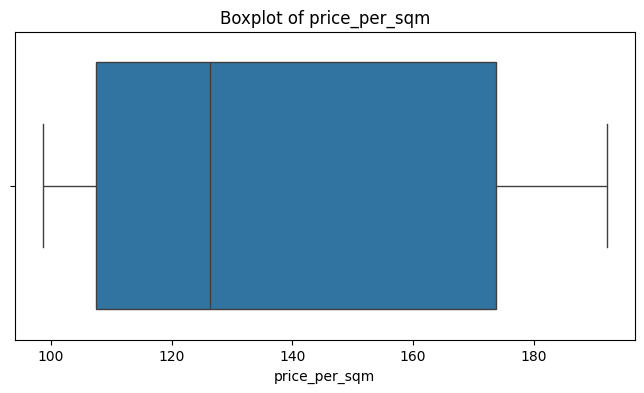

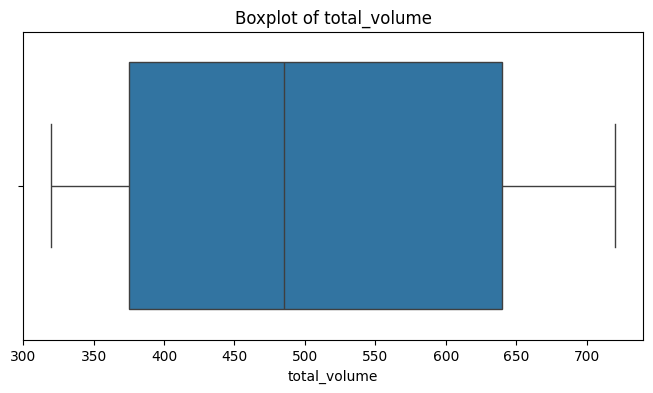

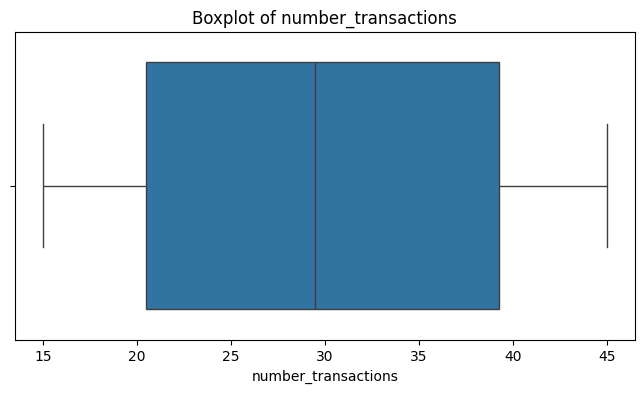

In [6]:
# Phan tich ngoai le
columns_check = ['price_per_sqm', 'total_volume', 'number_transactions']
for col in columns_check:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()
    logging.info(f'Boxplot for {col} displayed.')

## c) Phân tích theo quận (District Analysis):
- Tính giá trung bình, giá cao nhất, giá thấp nhất của mỗi quận
- Tính tỷ lệ thay đổi giá từ tháng 1 đến tháng 10 (%)
- Xác định quận có sự tăng giá cao nhất và thấp nhất

In [7]:
# Tinh gia tri trung binh, cao nhat, thap nhat theo quan
result = data.groupby('district')['price_per_sqm'].agg(['mean', 'max', 'min']).reset_index()
result.columns = ['district','avg_price_per_sqm', 'max_price_per_sqm', 'min_price_per_sqm']
print(result)

       district  avg_price_per_sqm  max_price_per_sqm  min_price_per_sqm
0       Ba Đình             126.35              127.2              125.5
1  Hai Bà Trưng             100.10              101.5               98.7
2     Hoàn Kiếm             190.70              192.1              189.3


In [8]:
data.head(10)

,month,month_name,date,district,price_per_sqm,total_volume,number_transactions
0,1,Tháng 1,2025-01-15,Ba Đình,125.5,450,28
1,1,Tháng 1,2025-01-15,Hoàn Kiếm,189.3,320,15
2,1,Tháng 1,2025-01-15,Hai Bà Trưng,98.7,680,42
3,2,Tháng 2,2025-02-15,Ba Đình,127.2,520,31
4,2,Tháng 2,2025-02-15,Hoàn Kiếm,192.1,350,18
5,2,Tháng 2,2025-02-15,Hai Bà Trưng,101.5,720,45


In [9]:
#Ty le thay doi gia tu thang 1 den thang 2
data_jan = data[data['date'].dt.month == 1]
data_feb = data[data['date'].dt.month == 2]
merged_data = pd.merge(data_jan, data_feb, on='district', suffixes=('_jan', '_feb'))
merged_data['price_change_rate'] = (merged_data['price_per_sqm_feb'] - merged_data['price_per_sqm_jan']) / merged_data['price_per_sqm_jan'] * 100
print(merged_data[['district', 'price_per_sqm_jan', 'price_per_sqm_feb', 'price_change_rate']])

       district  price_per_sqm_jan  price_per_sqm_feb  price_change_rate
0       Ba Đình              125.5              127.2           1.354582
1     Hoàn Kiếm              189.3              192.1           1.479134
2  Hai Bà Trưng               98.7              101.5           2.836879


In [11]:
#Xac dinh quan co su tang gia cao nhat va thap nhat
merged_data = merged_data.sort_values(by = 'price_change_rate', ascending= False)
print("Quan co su tang cao nhat:")
print(merged_data[['district', 'price_change_rate']].head(1))
print("Quan co su tang thap nhat:")
print(merged_data[['district', 'price_change_rate']].tail(1))

Quan co su tang cao nhat:
       district  price_change_rate
2  Hai Bà Trưng           2.836879
Quan co su tang thap nhat:
  district  price_change_rate
0  Ba Đình           1.354582


## d) Phân tích theo thời gian (Time Series Analysis):
- Tính giá trung bình toàn thành phố theo từng tháng
- Tính số lượng giao dịch theo tháng
- Xác định tháng có giá cao nhất và thấp nhất
- Tính tỷ lệ thay đổi giá hàng tháng (month-over-month growth)

In [12]:
giao_dich_theo_thang = data.groupby('month_name')['number_transactions'].sum().reset_index()
print(giao_dich_theo_thang)

  month_name  number_transactions
0    Tháng 1                   85
1    Tháng 2                   94


In [13]:
thang_co_gia = data.groupby('month_name')['price_per_sqm'].sum().reset_index()
thang_co_gia = thang_co_gia.sort_values(by = 'price_per_sqm', ascending= False)
print("Thang co gia cao nhat:")
print(thang_co_gia.head(1))
print("Thang co gia thap nhat:")
print(thang_co_gia.tail(1))

Thang co gia cao nhat:
  month_name  price_per_sqm
1    Tháng 2          420.8
Thang co gia thap nhat:
  month_name  price_per_sqm
0    Tháng 1          413.5


In [17]:
# Ty le thay doi gia hang thang
ty_le = ((thang_co_gia.iloc[0]['price_per_sqm'] - thang_co_gia.iloc[1]['price_per_sqm']) / thang_co_gia.iloc[1]['price_per_sqm']) * 100
print(f"Ty le thay doi giua thang 1 va 2 la: {ty_le:.2f}%")

Ty le thay doi giua thang 1 va 2 la: 1.77%


## e) Phân tích tương quan:
- Tính mối tương quan giữa giá nhà và số lượng giao dịch
- Tính mối tương quan giữa giá nhà và khối lượng giao dịch

In [20]:
# Moi tuong quan giua gia nha va so luong giao dich
def calculate_corr(data, col1, col2):
    try:
        correlation = data[col1].corr(data[col2])
        print(f"Moi tuong quan (corr) giua {col1} va {col2}:")
        return correlation
    except Exception as e:
        logging.error(f"Error calculating correlation between {col1} and {col2}: {e}")
print(calculate_corr(data, 'price_per_sqm', 'number_transactions'))
# Moi tuong quan giua gia nha va khoi luong giao dich
print(calculate_corr(data, 'price_per_sqm', 'total_volume'))

Moi tuong quan (corr) giua price_per_sqm va number_transactions:
-0.9528611514866024
Moi tuong quan (corr) giua price_per_sqm va total_volume:
-0.9248146942601948
